In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs


import random
import math

import pandas as pd
import numpy as np

import sklearn.metrics as sklm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

In [2]:
# Define base directory here
basedir=''

In [4]:
# RDKit object to provide the molecules one-by-one on request, plug in your molecular library in Smiles/SDF/etc.
library = Chem.SmilesMolSupplier(basedir+'.smiles', delimiter='\t', titleLine=False)

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

# Determine library smiles, please adjust this when using multi-line file formats
library_size = file_len(basedir+'.smiles')

In [5]:
################ QUESTION 2 COSINE vs TANIMOTO

random.seed(0)

# Fingerprint settings
radius = 4
bits = 1024

results = []

# Plug in the number of repetitions (no. of reference molecules in the range function)
for iteration in range(10):
    # Draw molecule randomly from *library*
    reference = library[random.randint(0, library_size)]
    
    refname = reference.GetProp('_Name')
    
    reference_nheavy = reference.GetNumHeavyAtoms()
    
    # Generate Morgan (ECFP-like) fingerprints
    fpref = AllChem.GetMorganFingerprintAsBitVect(reference,radius,nBits=bits)
    
    # Size expressed by the norm is the number of On bits
    reference_size = fpref.GetNumOnBits()
    
    for j in range(100):
        
        query = library[random.randint(0, library_size)]
        
        queryname = query.GetProp('_Name')
        
        query_nheavy = query.GetNumHeavyAtoms()
        
        fpquery = AllChem.GetMorganFingerprintAsBitVect(query,radius,nBits=bits)
        
        query_size = fpquery.GetNumOnBits()
        
        commonOnbits = len([i for i in fpref.GetOnBits() if i in fpquery.GetOnBits()])
        
        cosine = DataStructs.FingerprintSimilarity(fpref,fpquery, metric=DataStructs.CosineSimilarity)
        
        tanimoto = DataStructs.FingerprintSimilarity(fpref,fpquery)
        
        # Write out molecule names, sizes in nheavy and norm, Tanimoto and Euclidean
        results.append([refname,queryname,reference_nheavy,query_nheavy,
                        reference_size,query_size,tanimoto,cosine])

# Convert to pandas DataFrame and write to file
df = pd.DataFrame(results, columns=['reference','query','reference_nheavy','query_nheavy',
                           'reference_size','query_size','tanimoto','cosine'])
df.to_excel(basedir+'primary_results.xlsx')

In [6]:
################# QUESTION 2 COSINE vs TANIMOTO

results = []

# Split to smaller tables per reference molecule
for ref in df['reference'].unique():
    subdf = df[df.reference == ref]
    
    # Iterate over each pair of query molecules
    for iteration,i in enumerate(subdf.index):
        rowi = subdf.loc[i]
        for j in subdf.index[iteration+1:]:
            
            rowj = subdf.loc[j]
            
            # Calculate differences moving from molecule i to j
            delta_size = rowj['query_size']-rowi['query_size']
            deltaT = rowj['tanimoto']-rowi['tanimoto']
            deltaB = rowj['cosine']-rowi['cosine']
            
            # If the change of Tanimoto and Cosine is in the same direction (bigger Tanimoto similarity goes
            # together with bigger Cosine similarity), then *consistent* is True. Also True when the product is zero.
            if np.sign(deltaT) * np.sign(deltaB) != -1.0:
                consistent = True
            else:
                consistent = False
            
            results.append([delta_size,deltaT,deltaB,consistent])
# Convert to pandas DataFrame and write to file
resultsdf = pd.DataFrame(results, columns=['delta_size','deltaT','deltaB','consistent'])
resultsdf.to_excel(basedir+'BT_comparisons.xlsx')

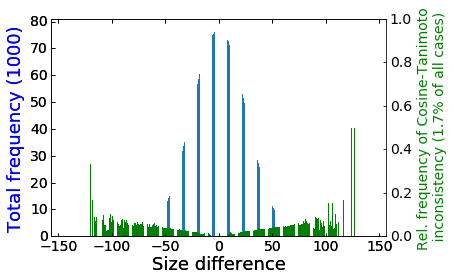

In [29]:
# Produce frequency plot

# Cases for each possible size difference where Tanimoto and Cosine are inconsistent
counts = resultsdf[resultsdf.consistent==False].delta_size.value_counts()
# Total cases for each possible size difference
counts_all = resultsdf.delta_size.value_counts()
# Arranged sequentially
counts_ref = [counts_all[i] for i in counts.index]
counts_ref = pd.Series(counts_ref,index=counts.index)
# For each size difference: ratio of B-T inconsistent cases over all cases
ratios = counts/counts_ref

total_inconsistent = len(resultsdf[resultsdf.consistent==False])
total = len(resultsdf)

total_ratio = total_inconsistent/total*100.0

# Prepare the plot
host = host_subplot(111, axes_class=AA.Axes)

par1 = host.twinx()

host.set_xlabel("Size difference")
host.set_ylabel("Total frequency (1000)")
par1.set_ylabel("Rel. frequency of Cosine-Tanimoto\n inconsistency ("+str(round(total_ratio,1))+"% of all cases)")

host.axis["bottom"].label.set_fontsize(18)
host.axis["left"].label.set_fontsize(18)
par1.axis["right"].label.set_fontsize(14)

p1 = host.bar(counts_all.index,counts_all.values/1000,width=0.2)
p2 = par1.bar(ratios.index,ratios.values,color='g')

host.axis["left"].label.set_color('b')
par1.axis["right"].label.set_color('g')

host.axis["left"].major_ticklabels.set_fontsize(14)
host.axis["bottom"].major_ticklabels.set_fontsize(14)
par1.axis["right"].major_ticklabels.set_fontsize(14)

par1.set_ylim(0, 1)
par1.axis["right"].toggle(all=True)

plt.xticks(size=12)
plt.yticks(size=12)

plt.margins(tight=False)

plt.savefig(basedir+'Morgan'+str(radius)+'_plot.png',dpi=300,bbox_inches='tight')